In [2]:
%pylab inline
%config InlineBackend.figure_format = 'retina'
style.use('dark_background')
from IPython.display import clear_output
from copy import copy, deepcopy
from tqdm import tqdm_notebook as tm
from tqdm import trange
from glob import glob
import os
import sys

Populating the interactive namespace from numpy and matplotlib


In [3]:
os.environ['CUDA_VISIBLE_DEVICES'] = "5"

In [4]:
import pandas as pd
import kts
from kts import *
features
helpers
features.define_in_scope(globals())
helpers.define_in_scope(globals())
train = kts.load('train')

[photo_urls, embeddings, has_embedding, hate_index, is_leader_v1, leader_type_v0]

[get_df_input, run_sql, get_uid, get_photo_urls, download_img, write_embedding, get_embedding, get_conn, compute_hate_index, multiclass_accuracy]

In [5]:
fs_1 = FeatureSet([embeddings, has_embedding, hate_index, is_leader_v1],
                  df_input=train,
                  target_column="is_leader",
                  description="Embeddings + fake hate index + leadership_target from csv"
                 )

In [7]:
fs_1[:]['is_leader'].mean()

0.15638602407748717

In [6]:
from sklearn.metrics import roc_auc_score
from sklearn.model_selection import StratifiedKFold

skf = StratifiedKFold(5, True, 42)
val = Validator(skf, roc_auc_score)

In [7]:
cb = zoo.bc.CatBoostClassifier(task_type="GPU", eval_metric="AUC")
val.score(cb, fs_1, 'default catboost', verbose=500)


Learning rate set to 0.115178
0:	learn: 0.5817623	test: 0.5812948	best: 0.5812948 (0)	total: 41.5ms	remaining: 41.4s
500:	learn: 0.7560865	test: 0.6010288	best: 0.6087783 (93)	total: 18.2s	remaining: 18.1s
999:	learn: 0.7752381	test: 0.5995104	best: 0.6087783 (93)	total: 33.2s	remaining: 0us
bestTest = 0.6087782681
bestIteration = 93
Shrink model to first 94 iterations.
Learning rate set to 0.115179
0:	learn: 0.5840433	test: 0.5791443	best: 0.5791443 (0)	total: 35.3ms	remaining: 35.3s
500:	learn: 0.7824899	test: 0.5805098	best: 0.6050424 (33)	total: 18.7s	remaining: 18.6s
999:	learn: 0.8002698	test: 0.5746548	best: 0.6050424 (33)	total: 34.1s	remaining: 0us
bestTest = 0.605042398
bestIteration = 33
Shrink model to first 34 iterations.
Learning rate set to 0.115179
0:	learn: 0.5849838	test: 0.5774786	best: 0.5774786 (0)	total: 33.9ms	remaining: 33.9s
500:	learn: 0.7584011	test: 0.5843297	best: 0.5991414 (5)	total: 17.9s	remaining: 17.8s
999:	learn: 0.7807804	test: 0.5823917	best: 0.5991

0.6043034305429769

In [8]:
lb

,Score,std,Model,FS,Description,FS description,Model source,FS source,Splitter
ID,,,,,,,,,
36D789,0.604303,0.0032273,cb_ed9,fs_1,default catboost,Embeddings + fake hate index + leadership_target from csv,"CatBoostClassifier(loss_function='Logloss', task_type='GPU', eval_metric='AUC')","FeatureSet(fc_before=stl.concat([embeddings, has_embedding, hate_index, is_leader_v1]), fc_after=stl.empty_like, target_column='is_leader', group_column=None)","StratifiedKFold(n_splits=5, random_state=42, shuffle=True)"


,face_0,face_1,face_2,face_3,face_4,face_5,face_6,face_7,face_8,face_9,...,face_120,face_121,face_122,face_123,face_124,face_125,face_126,face_127,has_embedding,hate_index
0,0.000000,0.000000,0.000000,0.168730,0.000000,0.004799,0.000000,0.183211,0.000000,0.564261,...,0.000000,0.000000,0.0,0.000000,0.338761,0.000000,0.000000,0.635856,0.613414,87.975891
1,0.196574,0.708816,0.338105,1.306641,1.015731,0.826114,0.284967,1.387545,0.432056,1.121940,...,0.506488,1.108457,0.0,0.399577,0.843323,0.922313,0.000000,0.769598,0.462072,32.613718
2,0.000000,0.000000,0.068081,0.378205,1.026496,0.580561,0.519721,0.000000,0.419541,0.000000,...,0.817483,0.000000,0.0,0.000000,0.356561,0.000000,0.000000,0.251271,0.421724,67.420377
3,0.000000,0.000000,0.222026,0.000000,0.000000,0.006896,0.000000,0.000000,0.000000,0.000000,...,0.000000,0.000000,0.0,0.000000,0.000000,0.000000,0.000000,0.000000,0.023999,95.326993
4,0.967056,0.562182,0.395393,2.276542,0.288692,0.099326,0.000000,0.271011,0.375888,0.733804,...,0.060020,0.479650,0.0,0.330109,0.285465,0.000000,0.199587,0.265124,0.339393,38.352510


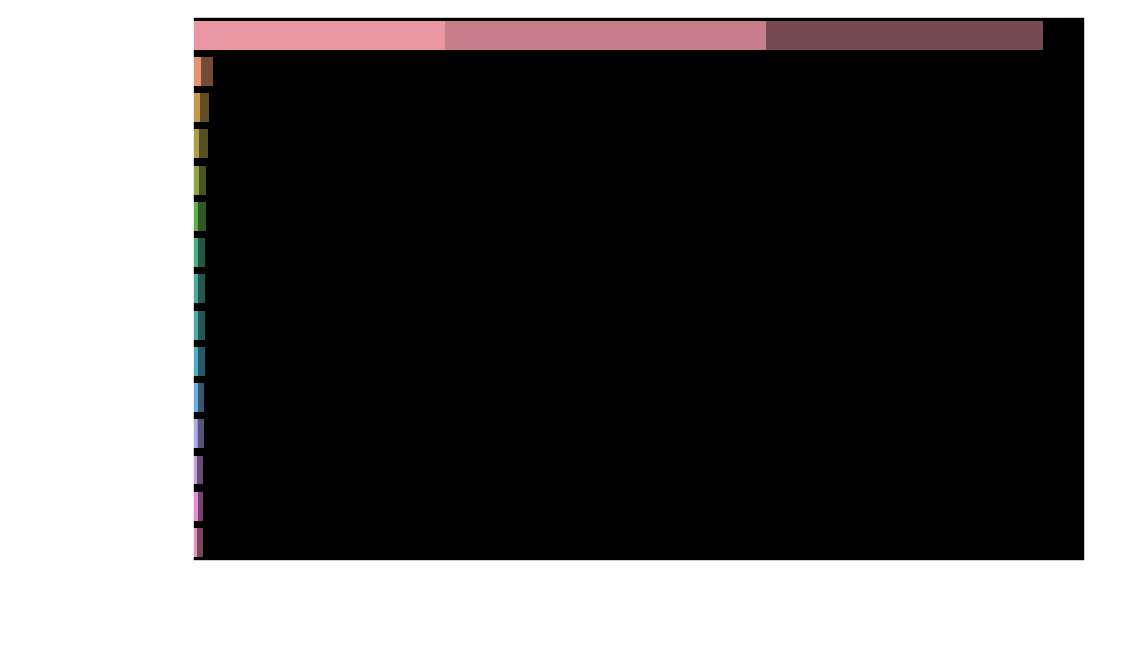

In [10]:
exp = lb['36D789']

exp.feature_importances(plot=True)
exp.feature_importances()

Interesting considering that hate index depends on index.

In [18]:
fs_1[:].groupby('is_leader')['hate_index'].mean()

is_leader
0    523.621622
1    736.829237
Name: hate_index, dtype: float64

Let's compute permutation importance instead of built-in.

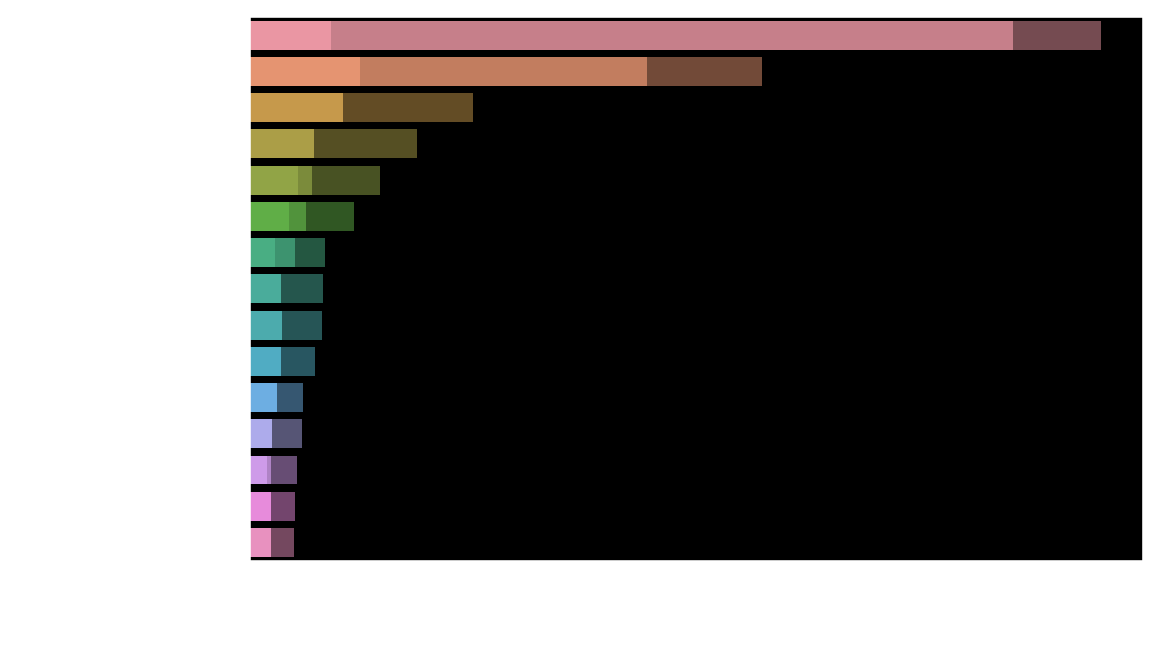

In [20]:
exp.set_df(train)
exp.feature_importances(True, selection.PermutationImportance(n_rows=5000))

Looks slightly better, but still...